# Capstone 2: Modeling

Looking back through the data, I realized I should include another feature. Snowfall data is not included in precipitation data and, given its potential for having a high level of impact on outages, it should be included.  The first part of this notebook will be used to import snowfall data using the NOAA API and incorporating it into the outage dataset.

In [1]:
# Import necessary modules to collect data and perform modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import json
import requests
import statistics
import time
from sklearn.preprocessing import StandardScaler

### Import additional Snowfall data

In [13]:
# # I will use the National Centers for Environmental Information API to pull weather data at the time and location of each outage event.
# # The API overview is located here: https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted

# # The code below pulls the NOAA API token from a local .env file.  API token can be requested here: https://www.ncdc.noaa.gov/cdo-web/token
# from dotenv import load_dotenv
# load_dotenv()
# token = os.getenv('NOAA_token')
# # print(token) # This checks that the token was pulled correctly

# # Setting a variable "header" equal to the token to be included in the GET request
# headers = {"token": token}

# # Pulling data from the API regarding state location ids. Creating a dictionary of state location ids to use in subsequent GET requests.
# url_1 = "https://www.ncei.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=100"
# r_1 = requests.get(url_1, headers = headers)
# json_data_1 = r_1.json()
# dict_data_1 = dict(json_data_1)
# # print(dict_data_1)
# FIPSID_dict = {dict['name']:dict['id'] for dict in dict_data_1['results']}
# # # print(FIPSID_dict)

# # Combining the FIPSID dictionaries
# # FIPSID_dict.update(US_TERR_FIPSID)
# print(FIPSID_dict)

{'Alabama': 'FIPS:01', 'Alaska': 'FIPS:02', 'Arizona': 'FIPS:04', 'Arkansas': 'FIPS:05', 'California': 'FIPS:06', 'Colorado': 'FIPS:08', 'Connecticut': 'FIPS:09', 'Delaware': 'FIPS:10', 'District of Columbia': 'FIPS:11', 'Florida': 'FIPS:12', 'Georgia': 'FIPS:13', 'Hawaii': 'FIPS:15', 'Idaho': 'FIPS:16', 'Illinois': 'FIPS:17', 'Indiana': 'FIPS:18', 'Iowa': 'FIPS:19', 'Kansas': 'FIPS:20', 'Kentucky': 'FIPS:21', 'Louisiana': 'FIPS:22', 'Maine': 'FIPS:23', 'Maryland': 'FIPS:24', 'Massachusetts': 'FIPS:25', 'Michigan': 'FIPS:26', 'Minnesota': 'FIPS:27', 'Mississippi': 'FIPS:28', 'Missouri': 'FIPS:29', 'Montana': 'FIPS:30', 'Nebraska': 'FIPS:31', 'Nevada': 'FIPS:32', 'New Hampshire': 'FIPS:33', 'New Jersey': 'FIPS:34', 'New Mexico': 'FIPS:35', 'New York': 'FIPS:36', 'North Carolina': 'FIPS:37', 'North Dakota': 'FIPS:38', 'Ohio': 'FIPS:39', 'Oklahoma': 'FIPS:40', 'Oregon': 'FIPS:41', 'Pennsylvania': 'FIPS:42', 'Rhode Island': 'FIPS:44', 'South Carolina': 'FIPS:45', 'South Dakota': 'FIPS:46',

In [15]:
# # Saving the FIPSID_dict to a txt file so I don't have to pull from the API again
# import csv

# with open('FIPSID_dict.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(FIPSID_dict.keys())
#     writer.writerow(FIPSID_dict.values())

In [34]:
# FIPSID_df = pd.read_csv('FIPSID_dict.csv')
# FIPSID_df = FIPSID_df.head().T.reset_index()
# FIPSID_df.rename(columns = {'index': 'State', 0: 'FIPSID'},inplace= True)
# FIPSID_df.set_index('State', inplace=True)
# FIPSID_df

,FIPSID
State,
Alabama,FIPS:01
Alaska,FIPS:02
Arizona,FIPS:04
Arkansas,FIPS:05
California,FIPS:06
Colorado,FIPS:08
Connecticut,FIPS:09
Delaware,FIPS:10
District of Columbia,FIPS:11


In [63]:
# # Import the outage_df
# outage_df = pd.read_csv('outage_df.csv', index_col= 0)
# outage_df.sort_index(inplace= True)
# outage_df['Datetime Event Began'] = pd.to_datetime(outage_df['Datetime Event Began'])
# outage_df.info()
# outage_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 419 entries, 0 to 418
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Datetime Event Began               419 non-null    datetime64[ns]
 1   State Affected                     419 non-null    object        
 2   NERC Region                        419 non-null    object        
 3   Alert Criteria                     419 non-null    object        
 4   Event Type                         415 non-null    object        
 5   Demand Loss (MW)                   419 non-null    float64       
 6   Number of Customers Affected       341 non-null    float64       
 7   State Avg Temp (F)                 419 non-null    float64       
 8   State Avg Windspeed (mph)          419 non-null    float64       
 9   State Avg Precipitation (mm)       419 non-null    float64       
 10  Monthly Net Energy for Load (GWh)  419 non-

,Datetime Event Began,State Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,State Avg Temp (F),State Avg Windspeed (mph),State Avg Precipitation (mm),Monthly Net Energy for Load (GWh),Monthly Peak Hour Demand (MW)
0,2018-01-02 10:00:00,New York,NPCC,Fuel supply emergencies that could impact elec...,System Operations,675.0,NaN,11.261429,11.499064,0.811386,63641.527716,110050.900000
1,2018-01-02 06:45:00,North Carolina,SERC,System-wide voltage reductions of 3 percent or...,Severe Weather,14998.0,NaN,18.694595,4.726667,0.000424,85958.000000,179134.000000
2,2018-01-12 13:08:00,Michigan,RF,Cyber event that causes interruptions of elect...,System Operations,41.0,23007.0,18.944706,15.835709,8.174586,76640.000000,137465.000000
3,2018-02-04 13:42:00,California,WECC,Physical attack that could potentially impact ...,Vandalism,9760.0,0.0,56.094913,1.118450,0.005626,66930.133379,127365.022436
4,2018-02-08 13:25:00,California,WECC,Electrical System Separation (Islanding) where...,System Operations,30.0,10900.0,56.660645,3.791818,0.001110,66930.133379,127365.022436


In [80]:
# outage_df.tail()

,Datetime Event Began,State Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,State Avg Temp (F),State Avg Windspeed (mph),State Avg Precipitation (mm),Monthly Net Energy for Load (GWh),Monthly Peak Hour Demand (MW)
414,2023-09-20 12:41:00,Oklahoma,MRO,Damage or destruction of a Facility within its...,NaN,51.0,NaN,72.140000,8.835755,5.993817,82787.594675,161995.921071
415,2023-10-15 07:16:00,California,WECC,"Unexpected Transmission loss within its area, ...",Other,72.0,6.0,63.246737,2.907970,0.038678,72217.336389,132030.087504
416,2023-10-26 12:41:00,Oregon,SERC,"Unexpected Transmission loss within its area, ...",Other,140.0,0.0,33.440000,3.695359,5.097192,70603.000000,144551.000000
417,2023-12-14 10:45:00,North Dakota,WECC,"Unexpected Transmission loss within its area, ...",NaN,20.0,1.0,33.195714,9.417349,0.004202,77873.145411,134110.475176
418,2023-12-27 14:44:00,North Dakota,MRO,Electrical System Separation (Islanding) where...,Severe Weather,14.0,8000.0,27.885714,8.030471,2.476271,86644.421423,144939.580999


In [85]:
# # For snowfall data

# # Setting request parameters to pull relevant weather data from the API.
# dataset_id = "GHCND" # This id corresponds to the data set with historical daily climate observations. Documentation for this dataset is here: https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt

# # Below are the datatype ids of the specific observations I would like to pull from each event
# snowfall_datatype_id = "SNOW" # Returns snowfall for date/location in mm

# # Creating a function for a GET request for weather data for each event in the outage_df. 
# # This code pulls the four datatypes listed above from all weather stations within the affected state, averages them over all the stations, and returns a single value for each datatype which will be incorporated in the outage_df
# def weather_data_request(event_index):
    
#     '''
#     This function will issue a request to the NOAA CDO API for the four parameters described for a specific event in the outage_df.
#     The only argument/parameter needed is the associated index number from the outage_df dataset above.
#     '''
    
#     start_date = outage_df['Datetime Event Began'][event_index].date()       # This will pull the start date from the outage dataset
#     end_date = start_date                                                    # The end date should correspond to the start date because we are only interested in the weather at the time the outage occurred
#     location_id = FIPSID_df.loc[outage_df['State Affected'][297]]['FIPSID']  # This pulls the affected state from the outage_df and the associated FIPSID from the FIPSID_df
#     url_3 = f"https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid={dataset_id}&locationid={location_id}&startdate={start_date}&enddate={end_date}&datatypeid={snowfall_datatype_id}&limit=1000"

#     max_retries = 3   # This api will often return a 503 error.  Creating a while loop to retry the request 3 times if a 503 error is returned
#     retries = 0
#     while retries <= max_retries:
#         try:
#             r_3 = requests.get(url_3, headers = headers)
#             print(r_3)
#             if r_3.text.strip():
#                 json_data_3 = r_3.json()
#                 dict_data_3 = dict(json_data_3)
#                 # print(dict_data_3)
#                 if dict_data_3 == {}:
#                     return 'No Data'
#                 else:
#                     avg_snowfall_mm = statistics.mean([dict['value'] for dict in dict_data_3['results'] if dict['datatype']=='SNOW']) 
#                     return [avg_snowfall_mm]
#             else:
#                 return 'No Data'
        
#         except requests.exceptions.HTTPError as e:
#             if response.status_code == 503:
#                 time.sleep(1)
#                 retries += 1
#             else:
#                 time.sleep(1)
#                 retries += 1

# # weather_data_dict = {}
# # last_index_updated = None

# for index, row in outage_df.iterrows():
#     if last_index_updated is not None and index <= last_index_updated:
#         continue
#     else:
#         weather_data_dict[index] = weather_data_request(index)
#         last_index_updated = index
        
# print(len(weather_data_dict))
# last_index_updated

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
419


418

In [87]:
# # Create a dataframe from the weather dictionary and add it to the outage_df
# weather_df = pd.DataFrame.from_dict(weather_data_dict,orient = 'index',columns = ['State Avg Snowfall (mm)'])
# outage_df = pd.concat([outage_df, weather_df], axis = 1)
# outage_df

,Datetime Event Began,State Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,State Avg Temp (F),State Avg Windspeed (mph),State Avg Precipitation (mm),Monthly Net Energy for Load (GWh),Monthly Peak Hour Demand (MW),State Avg Snowfall (mm)
0,2018-01-02 10:00:00,New York,NPCC,Fuel supply emergencies that could impact elec...,System Operations,675.0,NaN,11.261429,11.499064,0.811386,63641.527716,110050.900000,0.000000
1,2018-01-02 06:45:00,North Carolina,SERC,System-wide voltage reductions of 3 percent or...,Severe Weather,14998.0,NaN,18.694595,4.726667,0.000424,85958.000000,179134.000000,0.000000
2,2018-01-12 13:08:00,Michigan,RF,Cyber event that causes interruptions of elect...,System Operations,41.0,23007.0,18.944706,15.835709,8.174586,76640.000000,137465.000000,0.000000
3,2018-02-04 13:42:00,California,WECC,Physical attack that could potentially impact ...,Vandalism,9760.0,0.0,56.094913,1.118450,0.005626,66930.133379,127365.022436,0.000000
4,2018-02-08 13:25:00,California,WECC,Electrical System Separation (Islanding) where...,System Operations,30.0,10900.0,56.660645,3.791818,0.001110,66930.133379,127365.022436,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2023-09-20 12:41:00,Oklahoma,MRO,Damage or destruction of a Facility within its...,NaN,51.0,NaN,72.140000,8.835755,5.993817,82787.594675,161995.921071,0.000000
415,2023-10-15 07:16:00,California,WECC,"Unexpected Transmission loss within its area, ...",Other,72.0,6.0,63.246737,2.907970,0.038678,72217.336389,132030.087504,0.000000
416,2023-10-26 12:41:00,Oregon,SERC,"Unexpected Transmission loss within its area, ...",Other,140.0,0.0,33.440000,3.695359,5.097192,70603.000000,144551.000000,0.191142
417,2023-12-14 10:45:00,North Dakota,WECC,"Unexpected Transmission loss within its area, ...",NaN,20.0,1.0,33.195714,9.417349,0.004202,77873.145411,134110.475176,0.000000


In [119]:
# Save outage_df to a csv file:
# outage_df.to_csv('outage_df.csv')

### Inspect the new snowfall data

In [117]:
# outage_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Datetime Event Began,419,2021-02-18 00:59:41.527446528,2018-01-02 06:45:00,2020-02-13 06:45:00,2021-02-15 01:20:00,2022-05-05 09:20:00,2023-12-27 14:44:00,NaN
Demand Loss (MW),419.0,997.801909,1.0,24.0,107.0,411.5,133200.0,6877.425469
Number of Customers Affected,341.0,75091.366569,0.0,1185.0,18150.0,70000.0,4200000.0,264521.026457
State Avg Temp (F),419.0,54.56465,-10.687692,37.398938,58.357143,73.754777,89.111429,21.672102
State Avg Windspeed (mph),419.0,7.770007,0.89476,5.18706,7.388349,9.406164,24.091413,3.685304
State Avg Precipitation (mm),419.0,6.010057,0.0,0.127869,1.500546,7.13992,64.665455,10.285131
Monthly Net Energy for Load (GWh),419.0,68285.035967,16824.0,64758.0,71693.943097,79753.0,98533.095942,18078.587968
Monthly Peak Hour Demand (MW),419.0,128582.72567,36614.0,112713.702565,130749.667701,154864.0,209429.647324,35519.525256
State Avg Snowfall (mm),419.0,2.809365,0.0,0.0,0.0,0.40404,84.713004,10.603153


In [120]:
# # Look at avg snowfall by month to make sure the data makes sense (e.g., there should be near 0 mm during the summer time)

# month = outage_df['Datetime Event Began'].dt.month
# outage_df.pivot_table(index = month, values ='State Avg Snowfall (mm)', aggfunc = 'mean')

# # Looking at the below, the data passes the sense check.

,State Avg Snowfall (mm)
Datetime Event Began,
1,7.091554
2,5.455125
3,5.924919
4,1.075429
5,0.132039
6,0.000000
7,0.000000
8,0.000000
9,0.042188


### Fill in all missing data

In [127]:
# outage_df['Event Type'].value_counts()

Event Type
Severe Weather                              196
Transmission / Distribution Interruption     73
Vandalism                                    72
System Operations                            69
Other                                         4
Cyber Event                                   1
Name: count, dtype: int64

In [15]:
# # Let's get rid of any null values
# outage_df[outage_df['Event Type'].isna()] # Inspect the null values for Event Type

# # Manually updating the Event Type based on the Alert Criteria column
# outage_df.loc[405, 'Event Type'] = 'System Operations'
# outage_df.loc[410, 'Event Type'] = 'System Operations'
# outage_df.loc[414, 'Event Type'] = 'Vandalism'
# outage_df.loc[417, 'Event Type'] = 'Transmission / Distribution Interruption'

# outage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 419 entries, 0 to 418
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Datetime Event Began               419 non-null    object 
 1   State Affected                     419 non-null    object 
 2   NERC Region                        419 non-null    object 
 3   Alert Criteria                     419 non-null    object 
 4   Event Type                         419 non-null    object 
 5   Demand Loss (MW)                   419 non-null    float64
 6   Number of Customers Affected       341 non-null    float64
 7   State Avg Temp (F)                 419 non-null    float64
 8   State Avg Windspeed (mph)          419 non-null    float64
 9   State Avg Precipitation (mm)       419 non-null    float64
 10  Monthly Net Energy for Load (GWh)  419 non-null    float64
 11  Monthly Peak Hour Demand (MW)      419 non-null    float64
 12 

In [17]:
# # Filling the NAN values for customer affected with 0
# outage_df['Number of Customers Affected'].fillna(0, inplace= True)
# outage_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 419 entries, 0 to 418
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Datetime Event Began               419 non-null    object 
 1   State Affected                     419 non-null    object 
 2   NERC Region                        419 non-null    object 
 3   Alert Criteria                     419 non-null    object 
 4   Event Type                         419 non-null    object 
 5   Demand Loss (MW)                   419 non-null    float64
 6   Number of Customers Affected       419 non-null    float64
 7   State Avg Temp (F)                 419 non-null    float64
 8   State Avg Windspeed (mph)          419 non-null    float64
 9   State Avg Precipitation (mm)       419 non-null    float64
 10  Monthly Net Energy for Load (GWh)  419 non-null    float64
 11  Monthly Peak Hour Demand (MW)      419 non-null    float64
 12 

### Recreate dummy variable columns since the dataframe was modified

In [152]:
# # Create dummy variables for the following columns:
# outage_df_with_dummies = pd.get_dummies(data = outage_df, columns = ['State Affected', 'NERC Region', 'Event Type'], dtype = 'int')
# outage_df_with_dummies.head()

,Datetime Event Began,Alert Criteria,Demand Loss (MW),Number of Customers Affected,State Avg Temp (F),State Avg Windspeed (mph),State Avg Precipitation (mm),Monthly Net Energy for Load (GWh),Monthly Peak Hour Demand (MW),State Avg Snowfall (mm),...,NERC Region_SERC,NERC Region_SPP RE,NERC Region_TRE,NERC Region_WECC,Event Type_Cyber Event,Event Type_Other,Event Type_Severe Weather,Event Type_System Operations,Event Type_Transmission / Distribution Interruption,Event Type_Vandalism
0,2018-01-02 10:00:00,Fuel supply emergencies that could impact elec...,675.0,0.0,11.261429,11.499064,0.811386,63641.527716,110050.900000,0.0,...,0,0,0,0,0,0,0,1,0,0
1,2018-01-02 06:45:00,System-wide voltage reductions of 3 percent or...,14998.0,0.0,18.694595,4.726667,0.000424,85958.000000,179134.000000,0.0,...,1,0,0,0,0,0,1,0,0,0
2,2018-01-12 13:08:00,Cyber event that causes interruptions of elect...,41.0,23007.0,18.944706,15.835709,8.174586,76640.000000,137465.000000,0.0,...,0,0,0,0,0,0,0,1,0,0
3,2018-02-04 13:42:00,Physical attack that could potentially impact ...,9760.0,0.0,56.094913,1.118450,0.005626,66930.133379,127365.022436,0.0,...,0,0,0,1,0,0,0,0,0,1
4,2018-02-08 13:25:00,Electrical System Separation (Islanding) where...,30.0,10900.0,56.660645,3.791818,0.001110,66930.133379,127365.022436,0.0,...,0,0,0,1,0,0,0,1,0,0


In [181]:
# # Use standard scaler to scale the numeric features
# scaler = StandardScaler()
# outage_scaled = scaler.fit_transform(outage_df_with_dummies[['Demand Loss (MW)','Number of Customers Affected', 'State Avg Temp (F)', 'State Avg Windspeed (mph)', 'State Avg Precipitation (mm)', 'Monthly Net Energy for Load (GWh)', 'Monthly Peak Hour Demand (MW)', 'State Avg Snowfall (mm)']])

In [182]:
# outage_scaled

array([[-0.04699256, -0.25456277, -2.00049766, ..., -0.25715832,
        -0.52236001, -0.26527233],
       [ 2.03810784, -0.25456277, -1.65710447, ...,  0.97873193,
         1.42489816, -0.26527233],
       [-0.13928842, -0.15872769, -1.64554997, ...,  0.46269941,
         0.25036632, -0.26527233],
       ...,
       [-0.12487629, -0.25456277, -0.97590459, ...,  0.12836927,
         0.45010072, -0.24722386],
       [-0.14234554, -0.25455861, -0.98718997, ...,  0.53099123,
         0.1558117 , -0.26527233],
       [-0.143219  , -0.22123897, -1.23249834, ...,  1.01674607,
         0.46105372, -0.26527233]])

In [185]:
# # Combine the scaled data with the other data

# outage_df_scaled = pd.DataFrame(outage_scaled, columns = ['scaled_Demand Loss (MW)','scaled_Number of Customers Affected', 'scaled_State Avg Temp (F)', 'scaled_State Avg Windspeed (mph)', 'scaled_State Avg Precipitation (mm)', 'scaled_Monthly Net Energy for Load (GWh)', 'scaled_Monthly Peak Hour Demand (MW)', 'scaled_State Avg Snowfall (mm)'])
# outage_df_scaled_dummies = pd.concat([outage_df_with_dummies.drop(columns = ['Demand Loss (MW)','Number of Customers Affected', 'State Avg Temp (F)', 'State Avg Windspeed (mph)', 'State Avg Precipitation (mm)', 'Monthly Net Energy for Load (GWh)', 'Monthly Peak Hour Demand (MW)', 'State Avg Snowfall (mm)']), outage_df_scaled], axis = 1)
# outage_df_scaled_dummies.head()

,Datetime Event Began,Alert Criteria,State Affected_Alabama,State Affected_Arizona,State Affected_Arkansas,State Affected_California,State Affected_Colorado,State Affected_Connecticut,State Affected_Florida,State Affected_Georgia,...,Event Type_Transmission / Distribution Interruption,Event Type_Vandalism,scaled_Demand Loss (MW),scaled_Number of Customers Affected,scaled_State Avg Temp (F),scaled_State Avg Windspeed (mph),scaled_State Avg Precipitation (mm),scaled_Monthly Net Energy for Load (GWh),scaled_Monthly Peak Hour Demand (MW),scaled_State Avg Snowfall (mm)
0,2018-01-02 10:00:00,Fuel supply emergencies that could impact elec...,0,0,0,0,0,0,0,0,...,0,0,-0.046993,-0.254563,-2.000498,1.013082,-0.506059,-0.257158,-0.522360,-0.265272
1,2018-01-02 06:45:00,System-wide voltage reductions of 3 percent or...,0,0,0,0,0,0,0,0,...,0,0,2.038108,-0.254563,-1.657104,-0.826792,-0.585001,0.978732,1.424898,-0.265272
2,2018-01-12 13:08:00,Cyber event that causes interruptions of elect...,0,0,0,0,0,0,0,0,...,0,0,-0.139288,-0.158728,-1.645550,2.191229,0.210704,0.462699,0.250366,-0.265272
3,2018-02-04 13:42:00,Physical attack that could potentially impact ...,0,0,0,1,0,0,0,0,...,0,1,1.275575,-0.254563,0.070694,-1.807045,-0.584495,-0.075035,-0.034324,-0.265272
4,2018-02-08 13:25:00,Electrical System Separation (Islanding) where...,0,0,0,1,0,0,0,0,...,0,0,-0.140890,-0.209159,0.096830,-1.080764,-0.584935,-0.075035,-0.034324,-0.265272


In [190]:
# # Only keep numeric columns for modeling purposes:

# outage_df_scaled_dummies_numeric = outage_df_scaled_dummies.drop(columns = ['Datetime Event Began', 'Alert Criteria'])
# outage_df_scaled_dummies_numeric

# # outage_df_scaled_dummies.to_csv('outage_df_scaled_dummies.csv')
# # outage_df_scaled_dummies_numeric.to_csv('outage_df_scaled_dummies_numeric.csv')

### Modeling

We are going to use usupervised learning / clustering to model our data.  Let's start with KMeans

In [2]:
# Import dataframe to model
outage_df_scaled_dummies_numeric = pd.read_csv('outage_df_scaled_dummies_numeric.csv', index_col=0)
outage_df_scaled_dummies_numeric.head()

# Import outage_df
outage_df = pd.read_csv('outage_df.csv', index_col = 0)
outage_df.head()

,Datetime Event Began,State Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,State Avg Temp (F),State Avg Windspeed (mph),State Avg Precipitation (mm),Monthly Net Energy for Load (GWh),Monthly Peak Hour Demand (MW),State Avg Snowfall (mm)
0,2018-01-02 10:00:00,New York,NPCC,Fuel supply emergencies that could impact elec...,System Operations,675.0,0.0,11.261429,11.499064,0.811386,63641.527716,110050.900000,0.0
1,2018-01-02 06:45:00,North Carolina,SERC,System-wide voltage reductions of 3 percent or...,Severe Weather,14998.0,0.0,18.694595,4.726667,0.000424,85958.000000,179134.000000,0.0
2,2018-01-12 13:08:00,Michigan,RF,Cyber event that causes interruptions of elect...,System Operations,41.0,23007.0,18.944706,15.835709,8.174586,76640.000000,137465.000000,0.0
3,2018-02-04 13:42:00,California,WECC,Physical attack that could potentially impact ...,Vandalism,9760.0,0.0,56.094913,1.118450,0.005626,66930.133379,127365.022436,0.0
4,2018-02-08 13:25:00,California,WECC,Electrical System Separation (Islanding) where...,System Operations,30.0,10900.0,56.660645,3.791818,0.001110,66930.133379,127365.022436,0.0


In [3]:
from sklearn.cluster import KMeans
# Let's run the KMeans model for n_clusters ranging from 3 - 10 and plot the inertia for each model
n_clusters = range(3,21)  # established the range of cluster numbers to create KMeans model
KM_model_labels = {}      # dictionary to store the value of the labels created by each model
inertia_values = {}       # dictionary to store value of the inertia for each model

for n_cluster in n_clusters:
    KM_model = KMeans(n_clusters = n_cluster)
    KM_model.fit(outage_df_scaled_dummies_numeric)
    KM_model_labels[n_cluster] = KM_model.predict(outage_df_scaled_dummies_numeric)
    inertia_values[n_cluster] = KM_model.inertia_

print(inertia_values)

{3: 3268.5696114836164, 4: 2944.8599667915814, 5: 2716.1527573473422, 6: 2497.6552370065906, 7: 2160.4393095226883, 8: 2069.674519017313, 9: 1858.6659775966568, 10: 1698.7374050547064, 11: 1701.5728970147609, 12: 1621.4434620266916, 13: 1550.9153401953672, 14: 1507.1989199680033, 15: 1454.2162517629, 16: 1417.1641100162267, 17: 1332.001186007335, 18: 1387.332186857957, 19: 1266.4372648490016, 20: 1244.0171502953326}


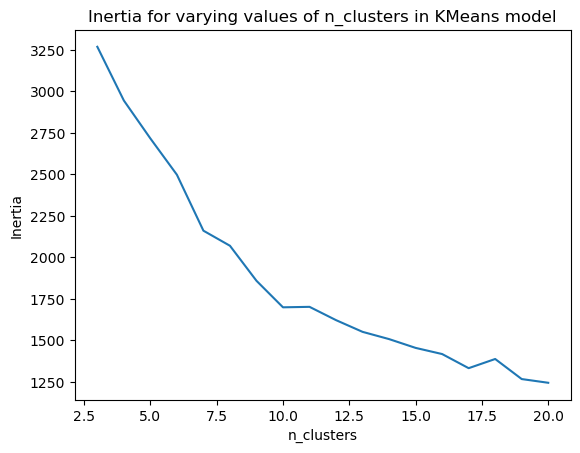

In [4]:
# Create a dataframe of the n_clusters and the associated inertia values
KM_inertia_values_df = pd.DataFrame.from_dict(data = inertia_values, orient = 'index', columns = ['Inertia'])
KM_inertia_values_df.index.rename('n_clusters', inplace=True)
KM_inertia_values_df

# Plot the intertia values on a lineplot
_ = sns.lineplot(data = KM_inertia_values_df, y = 'Inertia', x = 'n_clusters')
plt.title('Inertia for varying values of n_clusters in KMeans model')
plt.show()

### MeanShift Clustering

In [5]:
from sklearn.cluster import MeanShift

MS_model = MeanShift()
MS_model.fit(outage_df_scaled_dummies_numeric)
MS_model_labels = MS_model.labels_
cluster_centers = MS_model.cluster_centers_

labels_unique = np.unique(MS_model_labels)
n_clusters = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters)

number of estimated clusters : 5


### Hierarchical Clustering

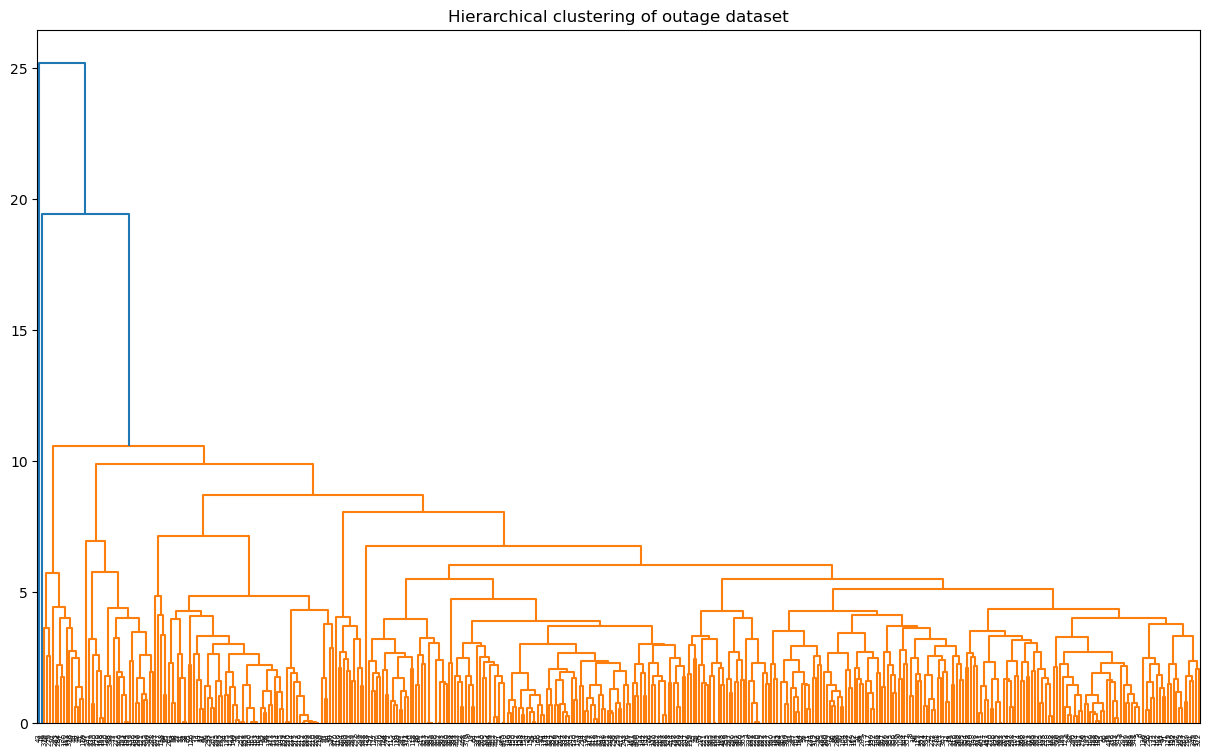

In [6]:
from scipy.cluster.hierarchy import linkage, dendrogram
plt.figure(figsize = (15,9))
mergings = linkage(outage_df_scaled_dummies_numeric, method = 'complete')
dendrogram(mergings, labels = outage_df_scaled_dummies_numeric.index)
plt.title('Hierarchical clustering of outage dataset')
plt.show()

In [7]:
# Let's get the label information of the dataset at a height of 8.
from scipy.cluster.hierarchy import fcluster
hierarchy_model_labels = fcluster(mergings, 8, criterion = 'distance')
print(hierarchy_model_labels)

[5 5 4 5 5 5 5 5 5 5 5 5 5 5 3 5 5 3 6 5 5 5 5 3 5 5 5 5 5 5 3 3 3 3 3 5 5
 3 2 5 1 1 5 7 1 5 1 2 1 5 3 5 5 3 5 5 5 5 3 5 5 5 3 5 5 3 5 5 3 5 5 5 5 2
 5 5 5 3 3 3 5 5 5 5 3 3 5 3 5 5 5 1 1 3 3 5 3 2 5 5 1 5 5 5 5 5 5 5 5 5 1
 1 5 5 5 5 4 5 5 5 2 2 5 3 5 5 3 5 5 5 5 5 5 3 5 3 5 5 3 2 3 5 5 5 5 3 5 5
 5 5 5 5 5 5 5 3 5 5 2 2 3 3 5 3 3 5 5 5 5 5 5 5 5 5 5 5 2 3 5 5 5 5 5 2 5
 5 5 5 5 5 5 5 5 2 2 2 5 5 5 5 5 3 5 5 4 5 5 3 3 3 3 3 3 3 3 5 3 5 3 3 5 5
 5 5 3 5 5 5 5 5 3 5 5 5 5 2 2 5 5 3 5 5 5 5 5 5 2 5 5 5 5 5 3 3 5 5 5 5 5
 5 5 3 5 5 5 5 5 5 5 5 5 2 5 5 5 3 5 5 5 1 4 5 3 1 1 5 5 5 2 4 5 5 4 3 5 3
 5 5 5 4 2 5 5 5 5 5 5 5 5 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5
 5 3 5 5 5 5 2 2 2 5 5 5 5 5 3 5 5 5 5 5 2 5 5 5 5 5 5 5 5 5 5 5 5 2 5 5 5
 5 5 5 3 5 3 5 3 1 1 5 5 5 5 5 5 5 5 4 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5]


### DBScan Clustering

In [8]:
from sklearn.cluster import DBSCAN

# The below code will fit a DBScan model for varying values of eps
DB_model_labels = {}
DB_model_n_clusters = {}
eps_values = np.arange(0.5, 11, 0.5)

for eps in eps_values:
    DB_model = DBSCAN(eps=eps).fit(outage_df_scaled_dummies_numeric)
    DB_model_labels[eps] = DB_model.labels_
    DB_model_n_clusters[eps] = len(set(DB_model_labels[eps])) - (1 if -1 in DB_model_labels[eps] else 0)

print(DB_model_n_clusters)

{0.5: 2, 1.0: 9, 1.5: 9, 2.0: 5, 2.5: 1, 3.0: 1, 3.5: 1, 4.0: 1, 4.5: 1, 5.0: 1, 5.5: 1, 6.0: 1, 6.5: 1, 7.0: 1, 7.5: 1, 8.0: 1, 8.5: 1, 9.0: 1, 9.5: 1, 10.0: 1, 10.5: 1}


From the above, it seems as though DBScan with EPS of 2.0 may be the best.

### Dimensionality Reduction

The below code will use t-SNE and PCA to reduce the dimensions of the dataset into 2D to allow for visualization of the dataset and the various clusters formed above.

### t-SNE

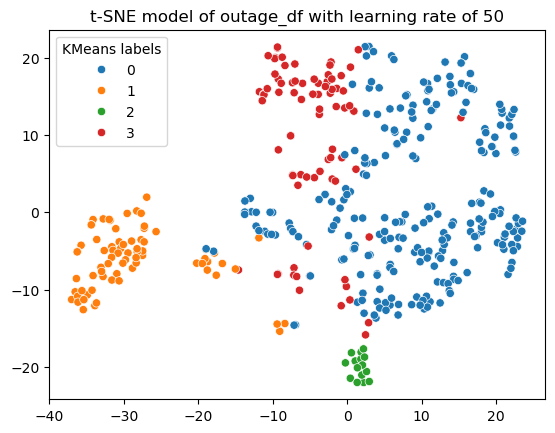

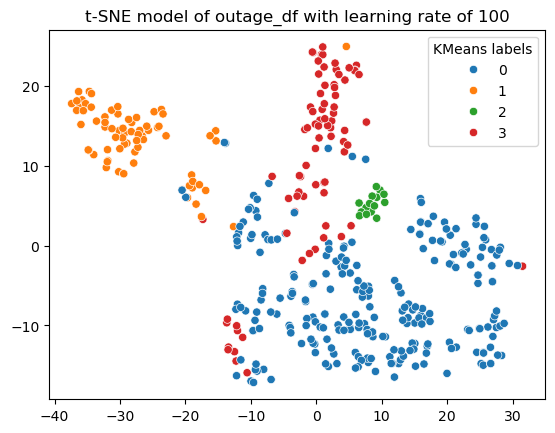

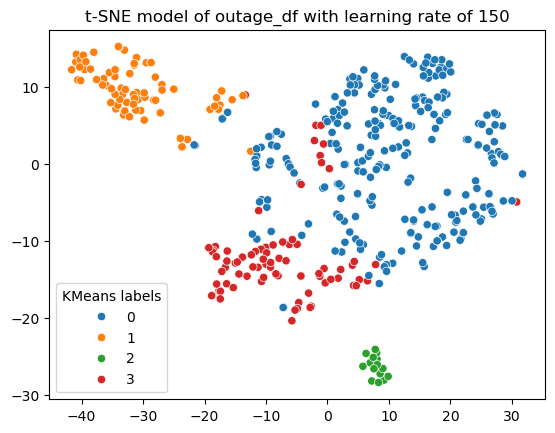

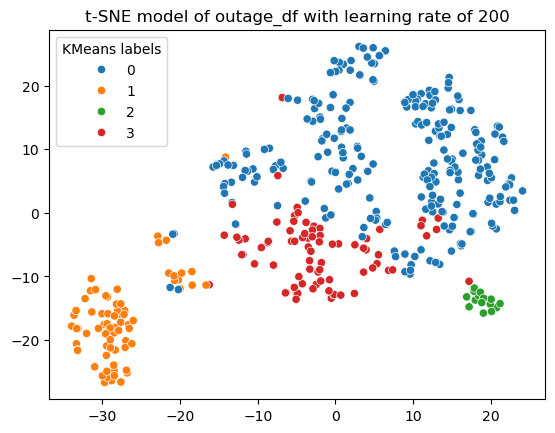

In [12]:
# Dimensionality reduction with t-SNE, plotted with KMeans labels
from sklearn.manifold import TSNE
learning_rate = np.arange(50,201,50)
KMeans_4_labels = pd.Series(data = KM_model_labels[4], name = 'KMeans labels') 
for rate in learning_rate:
    model = TSNE(learning_rate = rate)
    tsne_model = model.fit_transform(outage_df_scaled_dummies_numeric)
    x = tsne_model[:,0]
    y = tsne_model[:,1]
    _ = sns.scatterplot(x = x, y = y, hue = KMeans_4_labels, palette = 'tab10')  # This will plot the t-SNE transformation and the hue will indicate the labels assigned by the KMeans model
    plt.title(f't-SNE model of outage_df with learning rate of {rate}')
    plt.show()

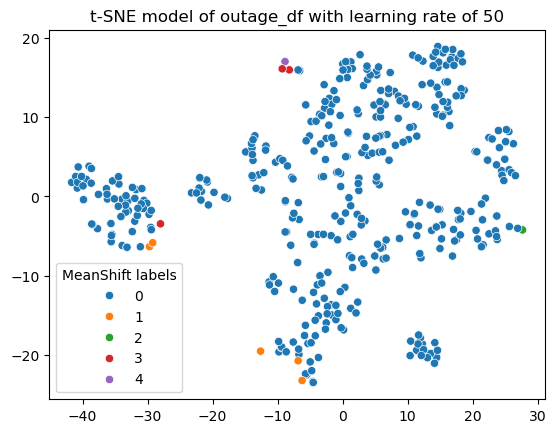

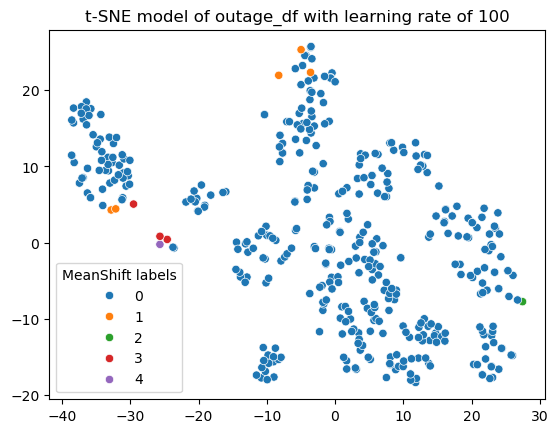

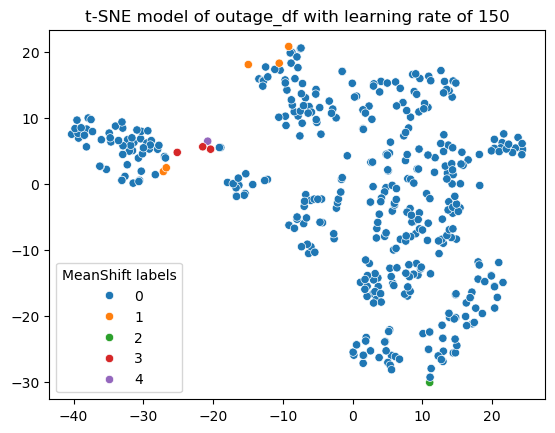

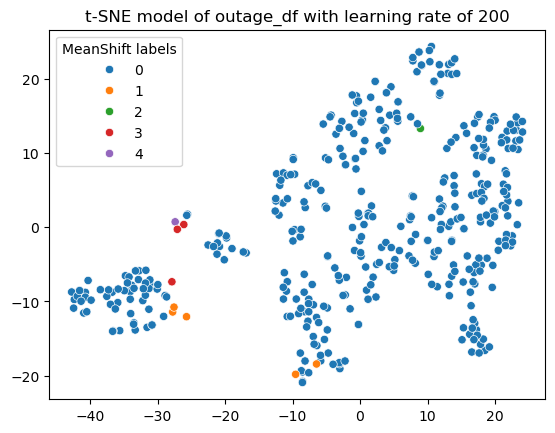

In [14]:
# Dimensionality reduction with t-SNE, plotted with MeanShift clustering labels
from sklearn.manifold import TSNE
learning_rate = np.arange(50,201,50)
MS_labels = pd.Series(data = MS_model_labels, name = 'MeanShift labels') 
for rate in learning_rate:
    model = TSNE(learning_rate = rate)
    tsne_model = model.fit_transform(outage_df_scaled_dummies_numeric)
    x = tsne_model[:,0]
    y = tsne_model[:,1]
    _ = sns.scatterplot(x = x, y = y, hue = MS_labels, palette = 'tab10')  # This will plot the t-SNE transformation and the hue will indicate the labels assigned by the KMeans model
    plt.title(f't-SNE model of outage_df with learning rate of {rate}')
    plt.show()

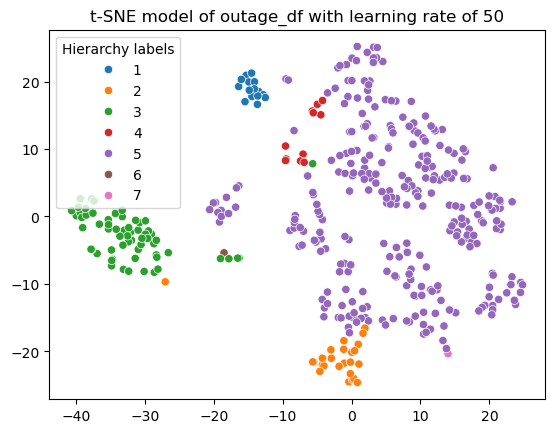

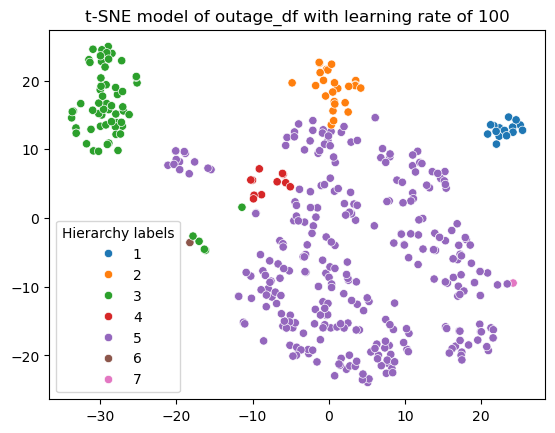

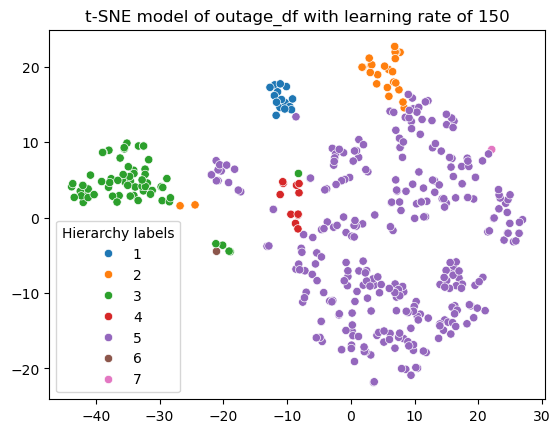

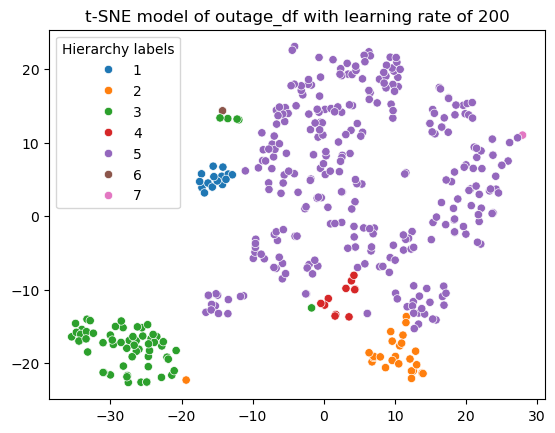

In [25]:
# Dimensionality reduction with t-SNE, plotted with Hierarchical clustering labels
from sklearn.manifold import TSNE
learning_rate = np.arange(50,201,50)
hierarchical_labels = pd.Series(data = hierarchy_model_labels, name = 'Hierarchy labels') 
for rate in learning_rate:
    model = TSNE(learning_rate = rate)
    tsne_model = model.fit_transform(outage_df_scaled_dummies_numeric)
    x = tsne_model[:,0]
    y = tsne_model[:,1]
    _ = sns.scatterplot(x = x, y = y, hue = hierarchical_labels, palette = 'tab10')  # This will plot the t-SNE transformation and the hue will indicate the labels assigned by the KMeans model
    plt.title(f't-SNE model of outage_df with learning rate of {rate}')
    plt.show()

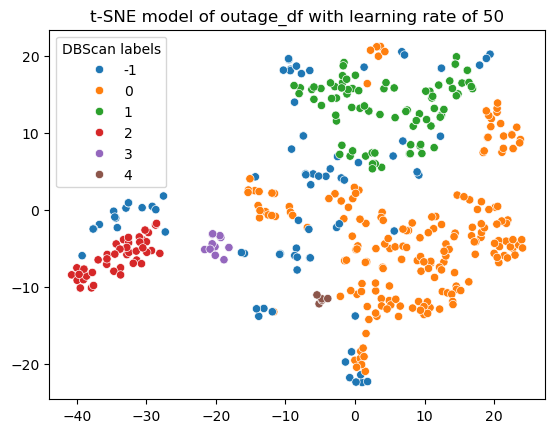

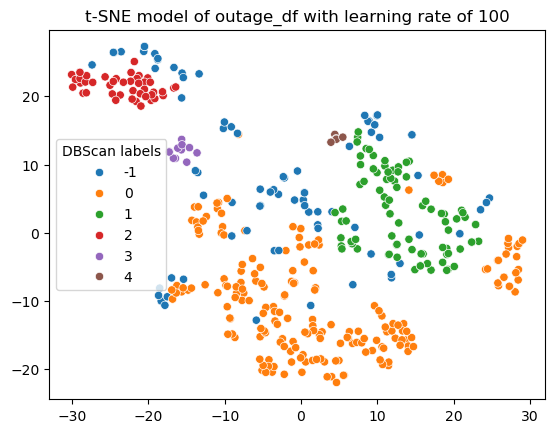

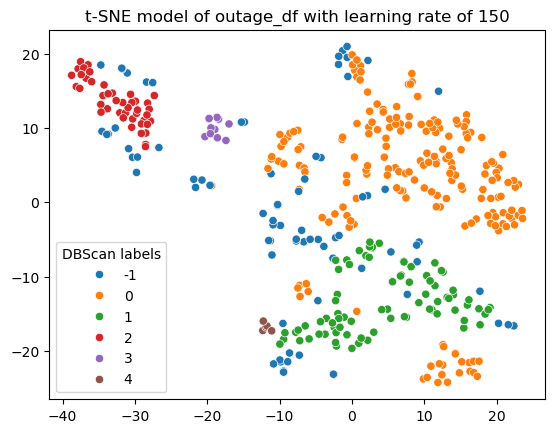

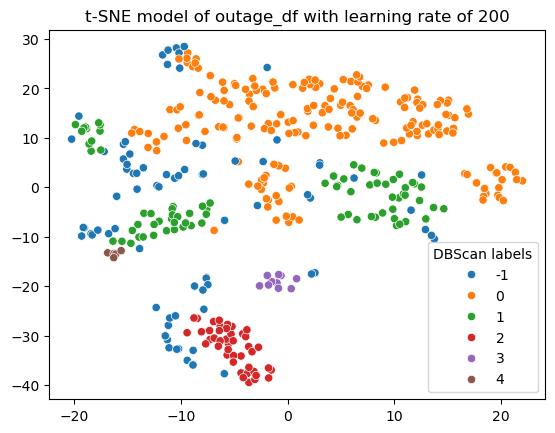

In [26]:
# Dimensionality reduction with t-SNE, plotted with DBScan clustering labels
from sklearn.manifold import TSNE
learning_rate = np.arange(50,201,50)
DBScan_labels = pd.Series(data = DB_model_labels[2.0], name = 'DBScan labels') 
for rate in learning_rate:
    model = TSNE(learning_rate = rate)
    tsne_model = model.fit_transform(outage_df_scaled_dummies_numeric)
    x = tsne_model[:,0]
    y = tsne_model[:,1]
    _ = sns.scatterplot(x = x, y = y, hue = DBScan_labels, palette = 'tab10')  # This will plot the t-SNE transformation and the hue will indicate the labels assigned by the KMeans model
    plt.title(f't-SNE model of outage_df with learning rate of {rate}')
    plt.show()

### PCA

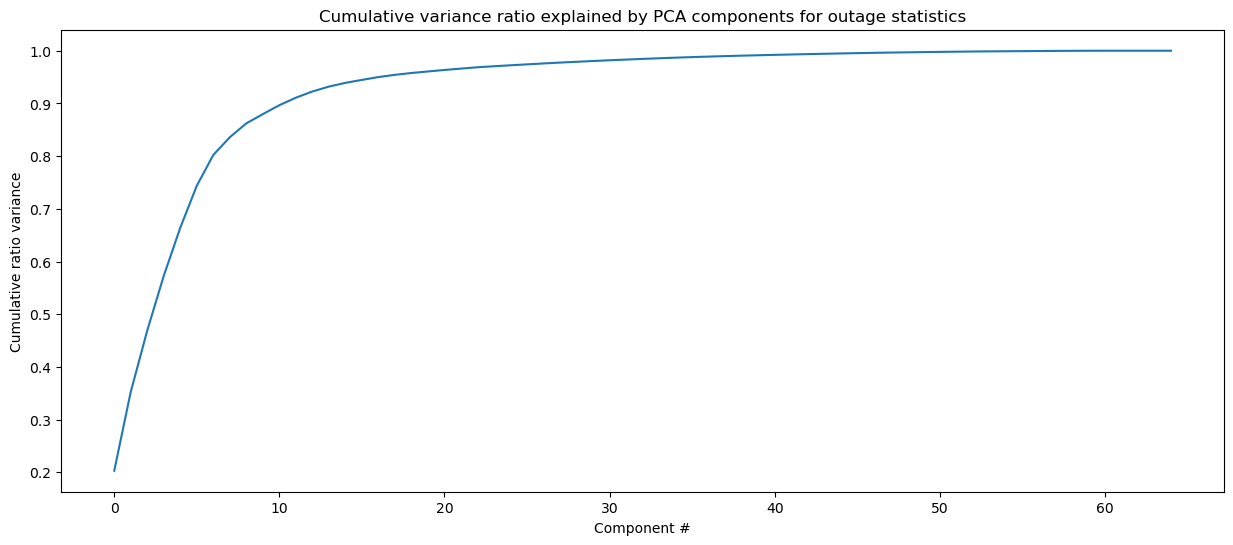

In [46]:
# The below code will conduct PCA varying the number of compents to see the optimal number for which to explain variance in the dataset
from sklearn.decomposition import PCA
outage_pca = PCA().fit(outage_df_scaled_dummies_numeric)
plt.subplots(figsize=(15, 6))
plt.plot(outage_pca.explained_variance_ratio_.cumsum())
plt.xlabel("Component #")
plt.ylabel("Cumulative ratio variance")
plt.title("Cumulative variance ratio explained by PCA components for outage statistics");

It looks like the dataset's variance can be mostly explained with the first 6 PCA features.  This doesn't help much for visualization as it is hard to plot more than 3 dimensions.

### Summary

In this notebook, I performed the following tasks:
1. **Import additional weather data:** I realized that the precipitation data did not include snowfall.  I felt that this could be an important feature to include in the dataset, therefore I imported the data for the outages from the NOAA api. Since new data was included I also had to inspect the data, reporform some EDA, recreate dummy variables and rescale the dataset.
2. **Fill in missing data:** There were a few remaining missing data that I had to fill in prior to modeling.  These were taken care of as follows:
   - **Event Type:** I manually filled in the remaining null values based on the description from the Alert Criteria column
   - **Number of Customers Affected:** I replaced null values with  0, under the assumption that if nothing was reported for this, more likely than not, that no customers were affected.  This is a major assumption that could be tweaked if needed.
3. **KMeans Model:**
   - Hyperparameters adjusted: n_clusters. I varied n_clusters for the KMeans model from 3 to 20 and plotted the resulting model inertia on a lineplot. This allowed me to visualize which was the ideal number of clusters.  From the plot, it seems as if 5 or 6 clusters is ideal, however no clear 'elbow' exists and inertia continues to drop quite consistently as the number of clusters increases.
4. **MeanShift Model:** I fit a MeanShift model to the dataset.  This model will output the number of clusters it found.  In this case, the number of clusters formed was 5.
5. **Hierarchical Clustering:** I created a dendrogram of the dataset, clustering based on euclidean distance.  This visualization helps to see how the data is clustered. I then extracted the cluster labels based on the height of the dendrogram that I believed explained a significant portion of the dataset, in this case at a height of 6.
6. **DBScan Clustering:**
   - Hyperparameters adjusted: eps. I varied eps from 0.5 to 10.5 and analyzed how many clusters were formed for each.  2.0 seemed the ideal eps as it formed 5 clusters whereas most of the other eps values formed only 1 cluster.
7. **Dimensionality Reduction:**
   - **t-SNE:** for each model above, I plotted their corresponding cluster labels against the 2 dimension t-SNE models of learning rates of 50, 100, 150, and 200. There were some very interesing resulting plots.  Most notably, the KMeans model seemed to form the best clusters that were highly visible in the t-SNE graph with a learning rate of 100.
   - **PCA:** I applied a PCA transformation to the dataset.  I plotted the explained variance vs. the number of PCA features.  The variance in the dataset isn't significantly accounted for until about 6 PCA features are included.  Therefore, PCA will not help with the visualization of this data.

In [15]:
# Add the KMeans labels to outage_df for further analysis
outage_df['KMeans Labels (4 clusters)'] = KMeans_4_labels

# Save the outage_df with the kmeans labels
outage_df.to_csv('outage_df_kmean.csv')